## Problem: Poisson GLM (Exponential Family)

---

### (a) Exponential-family form

$$
p(y;\lambda)
= \frac{1}{y!}\,\exp\bigl\{\log(\lambda)\,y \;-\;\lambda\bigr\}
$$

Equivalently, in the $\{\,b(y),\,\eta,\,T(y),\,A(\eta)\}$ notation:

$$
\begin{cases}
  b(y) = \displaystyle\frac{1}{y!}, \\[6pt]
  \eta = \log(\lambda), \\[6pt]
  T(y) = y, \\[6pt]
  A(\eta) = e^{\eta}.
\end{cases}
$$

---

### (b) Canonical response

Since $\eta = \theta^T x$, the conditional mean is

$$
h_\theta(x)
= \mathbb{E}[Y \mid x;\theta]
= \lambda
= e^{\eta}
= e^{\theta^T x}.
$$

---

### (c) Log-likelihood and gradient

The log-likelihood for a single example $(x^{(i)},y^{(i)})$ is

$$
\log p\bigl(y^{(i)}\mid x^{(i)};\theta\bigr)
=
-\log\bigl(y^{(i)}!\bigr)
\;+\;
\theta^T x^{(i)}\,y^{(i)}
\;-\;
e^{\theta^T x^{(i)}}.
$$

Taking the derivative w.r.t.\ $\theta_j$:

$$
\frac{\partial}{\partial \theta_j}
\,
\log p\bigl(y^{(i)}\mid x^{(i)};\theta\bigr)
=
\bigl(y^{(i)} - e^{\theta^T x^{(i)}}\bigr)\;x_j^{(i)}.
$$

A gradient‐ascent update step is

$$
\theta_j := 
\theta_j + \alpha\,\bigl(y^{(i)} - e^{\theta^T x^{(i)}}\bigr)\,x_j^{(i)}.
$$


In [23]:
import numpy as np
import util

from linear_model import LinearModel



class PoissonRegression(LinearModel):
    """Poisson Regression.

    Example usage:
        > clf = PoissonRegression(step_size=lr)
        > clf.fit(x_train, y_train)
        > clf.predict(x_eval)
    """

    def fit(self, x, y):
        """Run gradient ascent to maximize likelihood for Poisson regression.

        Args:
            x: Training example inputs. Shape (m, n).
            y: Training example labels. Shape (m,).
        """
        # *** START CODE HERE ***
        # split off the intercept
        intercept = x[:, [0]]                    # shape (m,1)
        features  = x[:, 1:]                     # all other columns

        # normalize only the real features
        mu   = np.mean(features, axis=0)
        sigma= np.std(features, axis=0)
        # avoid any zero‐σ columns
        sigma[sigma == 0] = 1

        X_norm = (features - mu) / sigma

        # re-attach intercept
        x = np.hstack([intercept, X_norm])      # shape (m, n)

        
        n = x.shape[1]
        m = x.shape[0]
        self.theta = np.zeros((n,1)) # Initialize theta to zeros, shape (n, 1)
        
        for i in range(m):
            eta = np.exp(x @ self.theta)          # shape (m,1)
            grad = x.T @ (y.reshape(-1,1) - eta)  # (n,1)
            self.theta += self.step_size * grad

        # *** END CODE HERE ***

    def predict(self, x):
        """Make a prediction given inputs x.

        Args:
            x: Inputs of shape (m, n).

        Returns:
            Floating-point prediction for each input, shape (m,).
        """
        # *** START CODE HERE ***
        predictions = np.exp(self.theta.T @ x.T).flatten()  # Calculate predictions using the exponential of the linear combination
        return predictions
        # *** END CODE HERE ***


In [31]:
import matplotlib.pyplot as plt
def main(lr, train_path, eval_path, pred_path):
    """Problem 3(d): Poisson regression with gradient ascent.

    Args:
        lr: Learning rate for gradient ascent.
        train_path: Path to CSV file containing dataset for training.
        eval_path: Path to CSV file containing dataset for evaluation.
        pred_path: Path to save predictions.
    """
    # Load training set
    x_train, y_train = util.load_dataset(train_path, add_intercept=True)

    # The line below is the original one from Stanford. It does not include the intercept, but this should be added.
    # x_train, y_train = util.load_dataset(train_path, add_intercept=False)

    # *** START CODE HERE ***
    # Fit a Poisson Regression model
    clf = PoissonRegression(step_size=lr)
    clf.fit(x_train, y_train)

    x_eval, y_eval = util.load_dataset(eval_path, add_intercept=True)


    predictions = clf.predict(x_eval)
    
    # Save predictions to pred_path
    np.savetxt(pred_path, predictions, delimiter=',', fmt='%.6f')
    eps = 1e-8
    mae  = np.mean(np.abs(predictions - y_eval))
    rmse = np.sqrt(np.mean((predictions - y_eval)**2))
    mape = np.mean(np.abs((predictions - y_eval) / (y_eval + eps))) * 100.0

    # Poisson deviance:
    # guard log argument by replacing any zero y_true with eps
    y_safe = np.where(y_eval==0, eps, y_eval)
    deviance = 2 * np.sum(y_eval * np.log(y_safe / predictions) - (y_eval - predictions))

    # (Optionally) exact‐match “accuracy”:
    exact_match = np.mean(np.round(predictions) == y_eval)

    print(f"MAE:    {mae:.4f}")
    print(f"RMSE:   {rmse:.4f}")
    print(f"MAPE:   {mape:.2f}%")
    print(f"Deviance: {deviance:.4f}")
    print(f"Exact‐match: {exact_match:.4f}")

    plt.figure(figsize=(6,6))
    plt.scatter(y_eval, predictions, alpha=0.5)
    # 45° reference line
    vmin = min(y_eval.min(), predictions.min())
    vmax = max(y_eval.max(), predictions.max())
    plt.plot([vmin, vmax], [vmin, vmax], 'k--', linewidth=1)
    plt.xlim(vmin, vmax)
    plt.ylim(vmin, vmax)
    plt.xlabel('True y')
    plt.ylabel('Predicted ŷ')
    plt.title('Poisson Regression: Predicted vs. True')
    plt.tight_layout()
    plt.savefig('pred_vs_true.png')
    plt.show()

    # 2) Residuals histogram
    residuals = predictions - y_eval
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30, edgecolor='k', alpha=0.7)
    plt.xlabel('Residual (ŷ – y)')
    plt.ylabel('Count')
    plt.title('Residuals Distribution')
    plt.tight_layout()
    plt.savefig('residuals_hist.png')
    plt.show()
    # Run on the validation set, and use np.savetxt to save outputs to pred_path
    # *** END CODE HERE ***

MAE:    2679774.5188
RMSE:   3319100.0276
MAPE:   369.34%
Deviance: 613640958.9130
Exact‐match: 0.0000


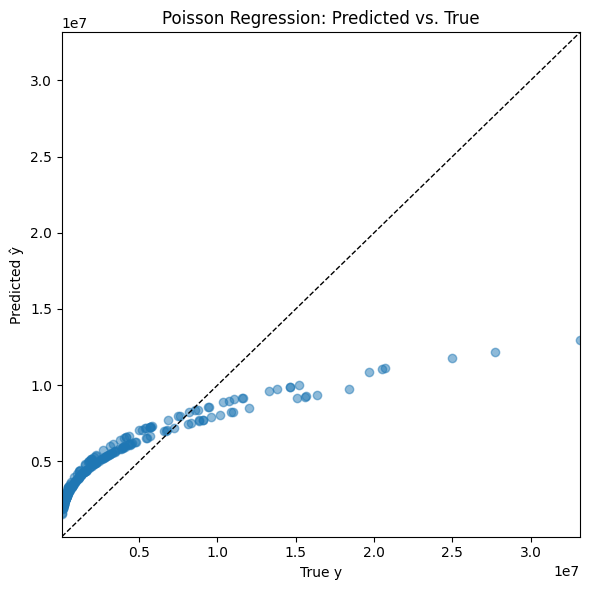

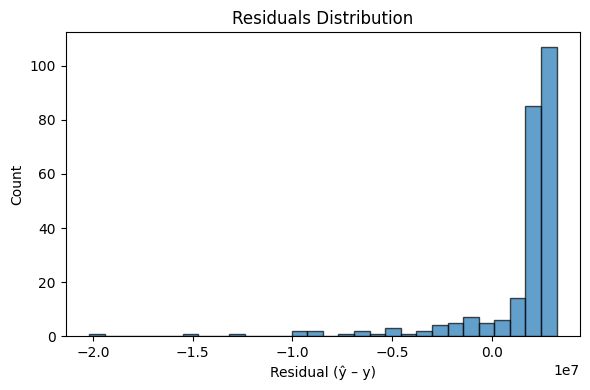

In [36]:
if __name__ == '__main__':
    main(lr=1e-10,
         train_path='./data/ds4_train.csv',
         eval_path='./data/ds4_valid.csv',
         pred_path='./data/poisson_predictions.csv')